In [ ]:
# !pip install sentence_transformers

In [1]:
# import libraries
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import re
# from sentence_transformers import SentenceTransformer
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 1 - Dataset 

In [4]:
with open('/content/drive/MyDrive/enc_bar', 'rb') as f:
    X = pickle.load(f)

In [5]:
all_songs = pd.read_csv('/content/drive/MyDrive/all_songs.csv')
all_songs['artist'] = all_songs['artist'].astype('category') # convert to categorical to get numerical classes
some_songs = all_songs.loc[all_songs['lyrics'].str.startswith('[').fillna(False)]
some_songs

,song title,lyrics,artist
0,In Da Club,"[Intro]\nGo, go, go, go, go, go\nGo Shorty, it...",50 Cent
1,21 Questions,[Ad-Libs]\nNew York City\nYou are now rockin'\...,50 Cent
2,Many Men (Wish Death),"[Skit]\nMan, we gotta go get somethin' to eat\...",50 Cent
3,My Life,"[Chorus]\nMy, yeah, yeah, mmm\nMy life, my lif...",50 Cent
4,Patiently Waiting,"[Intro]\nHey Em, you know you're my favorite w...",50 Cent
...,...,...,...
575,Cruisin’,"[Intro]\n(Crusin')\n\n[Verse 1]\nBaby, let's c...",Smokey Robinson
576,Really Gonna Miss You,[Verse 1]\nReally gonna miss you\nIt's really ...,Smokey Robinson
579,The Agony and the Ecstasy,[Verse 1]\nWhat's it all about this crazy love...,Smokey Robinson
582,Ooh Baby Baby,[Verse 1]\nI did you wrong\nMy heart went out ...,Smokey Robinson


In [6]:
# create labels
y = some_songs.artist.cat.codes.values

# del idx 158 & 224
y = np.delete(y, [158,224])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, shuffle = True)

y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# 2 - Model Construction

## 2.1 - Word Level RNN

In [8]:
class WordLevelRNN(nn.Module):
    def __init__(self, word_num_hidden):
        super().__init__()
        
        self.word_context_weights = nn.Parameter(torch.rand(2 * word_num_hidden, 1))
        self.word_context_weights.data.uniform_(-0.25, 0.25)
        
        self.GRU = nn.GRU(word_num_hidden, word_num_hidden, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * word_num_hidden, 2 * word_num_hidden, bias=True)
        
        self.soft_word = nn.Softmax()
        
    def forward(self, x):
        # RNN layer
        h, _ = self.GRU(x)
        x = torch.tanh(self.linear(h))
        
        # attention layer
        x = torch.matmul(x, self.word_context_weights)
        x = x.squeeze(dim=2)
        
        # output layer
        x = self.soft_word(x.transpose(1, 0))
        x = torch.mul(h.permute(2, 0, 1), x.transpose(1, 0))
        x = torch.sum(x, dim=2).transpose(1, 0).unsqueeze(0)
        
        # should output bars combined into one verse embedding
        return x

## 2.2 - Sentence Level RNN

In [9]:
class SentLevelRNN(nn.Module):
    def __init__(self, sentence_num_hidden, word_num_hidden, target_class):
        super().__init__()
        
        self.sentence_context_weights = nn.Parameter(torch.rand(2 * sentence_num_hidden, 1))
        self.sentence_context_weights.data.uniform_(-0.1, 0.1)
        
        self.sentence_gru = nn.GRU(2 * word_num_hidden, sentence_num_hidden, bidirectional=True)
        self.sentence_linear = nn.Linear(2 * sentence_num_hidden, 2 * sentence_num_hidden, bias=True)
        
        self.fc = nn.Linear(2 * sentence_num_hidden , target_class)
        self.soft_sent = nn.Softmax()
        
    def forward(self,x):
        # RNN layer
        sentence_h,_ = self.sentence_gru(x)
        x = torch.tanh(self.sentence_linear(sentence_h))
        
        # attention layer
        x = torch.matmul(x, self.sentence_context_weights)
        x = x.squeeze(dim=2)
        
        # output layer
        x = self.soft_sent(x.transpose(1,0))
        x = torch.mul(sentence_h.permute(2, 0, 1), x.transpose(1, 0))
        x = torch.sum(x, dim=1).transpose(1, 0).unsqueeze(0)
        x = self.fc(x.squeeze(0))
        return x

## 2.3 - HAN

In [10]:
class HAN(nn.Module):

    def __init__(self, word_num_hidden, sentence_num_hidden, target_class):
        super().__init__()
        self.word_attention_rnn = WordLevelRNN(word_num_hidden)
        self.sentence_attention_rnn = SentLevelRNN(sentence_num_hidden, word_num_hidden, target_class)

    def forward(self, x):
        # todo include the fact that the embeddings are already passed in
        
        # x is list of tensors of size [1: #bar: #embedding size]
#         x = x.permute(1, 2, 0) # Expected : # sentences, # words, batch size

        num_verses = len(x)
        word_attentions = None
        
        for i in range(num_verses):
            # x[i] is a verse of size (1, #bars, 768)
            if len(x[i].size()) != 3:
                continue
            
            input = x[i].to(device)
            word_attn = self.word_attention_rnn(input)
            if word_attentions is None:
                word_attentions = word_attn
            else:
                word_attentions = torch.cat((word_attentions, word_attn), 0)
        return self.sentence_attention_rnn(word_attentions)

# 3 - Model Training

In [25]:
# model definition
word_num_hidden = 768
sentence_num_hidden = 128
target_class = 13

model = HAN(word_num_hidden, sentence_num_hidden, target_class).to(device)

# define model parameters
num_epochs = 5
lr = 0.05

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
torch.cuda.empty_cache()

In [27]:
avg_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    for x_val, y_val in zip(x_train, y_train):
        model.train()
        optimiser.zero_grad()

        # x_val has length = # of verses
        try:
            out = model(x_val)
        except AttributeError:
            continue
        label = torch.tensor([y_val]).to(device)
        train_loss = criterion(out, label)
        epoch_losses.append(train_loss.item())
        train_loss.backward()
        optimiser.step()
    avg_loss = sum(epoch_losses)/len(epoch_losses)
    avg_losses.append(avg_loss)
    print('Epoch: {} .......... Training Loss: {}'.format(epoch, avg_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 .......... Training Loss: 10.18008034476378
Epoch: 1 .......... Training Loss: 9.914139961009448
Epoch: 2 .......... Training Loss: 9.932815305495618
Epoch: 3 .......... Training Loss: 9.468895170079339
Epoch: 4 .......... Training Loss: 10.101208521563713


# 4 - Model Evaluation

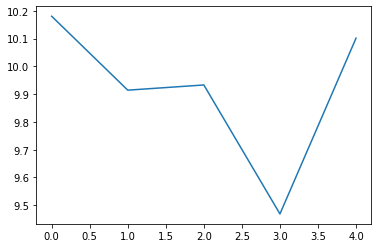

In [28]:
plt.plot(np.arange(start=0, stop=len(avg_losses)), np.array(avg_losses))
plt.show()

In [29]:
def Accuracy(xs, ys):
    correct = 0
    for i in range(len(xs)):
        # run through model
        test_sample = xs[i]

        try:
            pred = model(test_sample)
        except AttributeError:
            print('Test Sample #{} identified as NoneType'.format(i))
            continue
        # calc argmax
        pred = torch.argmax(pred).item()
        # sum up correct predictions
        correct += (pred == ys[i].item())
    return correct/len(xs)

test_acc = Accuracy(x_test, y_test)
print('{:.3f}% Test Accuracy'.format(test_acc*100))

train_acc = Accuracy(x_train, y_train)
print('{:.3f}% Train Accuracy'.format(train_acc*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10.204% Test Accuracy
Test Sample #310 identified as NoneType
9.840% Train Accuracy


In [30]:
len(x_train)

437

In [31]:
len(x_test)

49